# Обучение модели для сегментации мозга

## Подготовка среды

In [1]:
import datetime
import os
# from typing import Optional

%matplotlib inline
import matplotlib.pyplot as plt

# import matplotlib.animation
# import models.metrics

plt.rcParams["animation.html"] = "jshtml"
import tensorflow as tf
# from IPython.display import clear_output
# import matplotlib.pyplot as plt
from loader_data import PreprocessLoadData, AnimateView
from models.model_MultiReaUNet2d import Model2DMultiResUnet
from models.model_UNet2d import Model2DUnet
import numpy as np

gpu_device = tf.config.experimental.list_physical_devices('GPU')[0]
tf.config.experimental.set_memory_growth(gpu_device, True)



## Определяем ключевые параметры

 - **KERNEL_DIM** - Размер изображения которое подаем на вход сети. Независимо от размера исходного изображения, генератор будет делить исходное изображение на куски размером KERNEK_DIM
 - **STEP_WINDOW** - Разбиение исходного изображения на куски размером KERNEK_DIM происходит по принципу плавающего окна. STEP_WINDOW задает шаг смещения окна.
 - **BATCH_SIZE** - Количество кусков в одном батче
 - **Model** - Класс модели, которую будем обучать.

In [32]:
STEP_WINDOW = (256, 256)
BATCH_SIZE = 8
KERNEL_DIM = (256, 256)

# Model2DMultiResUnet or Model2DUnet
Model = Model2DMultiResUnet


## Проверяем наличие данных для обучения

### Находим обучающие данные 

In [33]:

loader = PreprocessLoadData(kernel_size=KERNEL_DIM, step=STEP_WINDOW, batch_size=BATCH_SIZE)
loader.find_files()
print(f"Был найден набор из {loader.length_data()} пар данных")


Был найден набор из 369 пар данных


### Получаем генератор данных

In [34]:
train_dataset = loader.get_generator_data("train",
                                          threshold=0.05,
                                          random_change_plane=False,
                                          augmentation=False)
test_dataset = loader.get_generator_data("test",
                                         threshold=0.05,
                                         random_change_plane=False,
                                         augmentation=False)


#### Проверяем как работает генератор

(8, 256, 256, 3)
(8, 256, 256, 3)


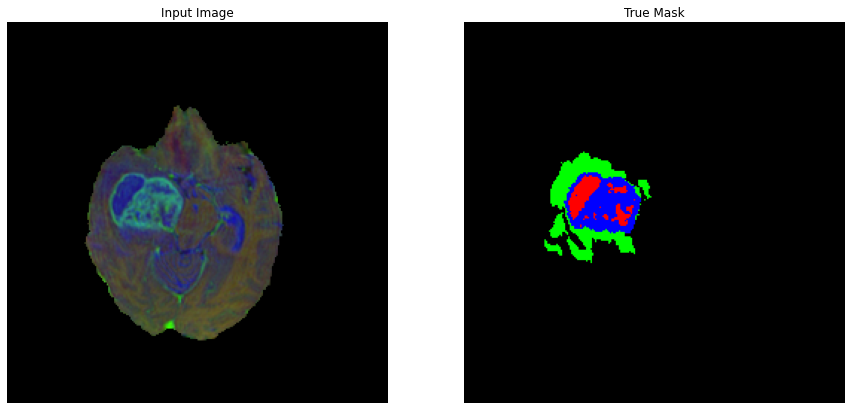

In [35]:
def display(display_list):
  plt.figure(figsize=(15, 15))
  title = ['Input Image', 'True Mask', 'Predicted Mask']
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()
for image, mask in train_dataset:
    print(image.shape)
    print(mask.shape)
    sample_image, sample_mask = image[0,...], mask[0,...]
    break
display([sample_image, sample_mask])


## Создаем модель

 - n_channels: Размер канала входных данных.
 - initial_learning_rate: Начальная скорость обучения модели.
 - n_classes: Количество классов, которые изучает модель .
 - start_val_filters: Количество фильтров, которые будет иметь первый слой в сети.
 - list_metrics: Список метрик, для обучения модели.
 - type_up_convolution: тип повышающего слоя. up_sampling_3d использует меньше памяти.
 - pool_size: Размер пула для максимальных операций объединения. Целое число или кортеж.
 - input_img_shape: Форма входных данных кортеж(3N) или целое число (если форма соответствует кубу).
 - depth: глубина модели. Уменьшение глубины может уменьшить объем памяти, необходимый для тренировки.


In [36]:
manager_model = Model(depth=5, start_val_filters=8, input_img_shape=KERNEL_DIM, n_classes=3, n_channels=3,
                                    initial_learning_rate=0.99)


### Проверяем как работает не обученная модель

(8, 256, 256, 3)
(8, 256, 256, 3)


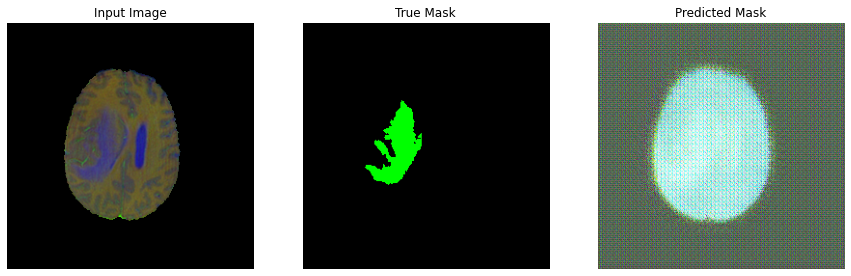

(8, 256, 256, 3)
(8, 256, 256, 3)


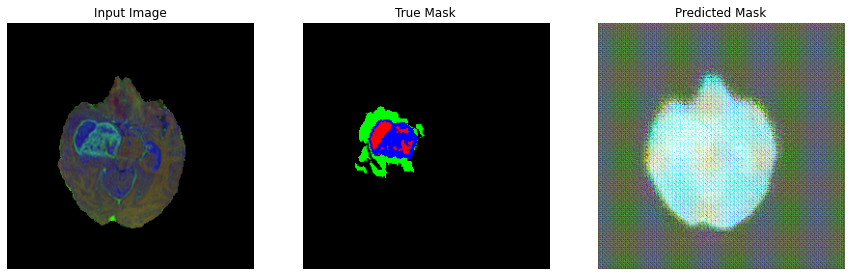

(8, 256, 256, 3)
(8, 256, 256, 3)


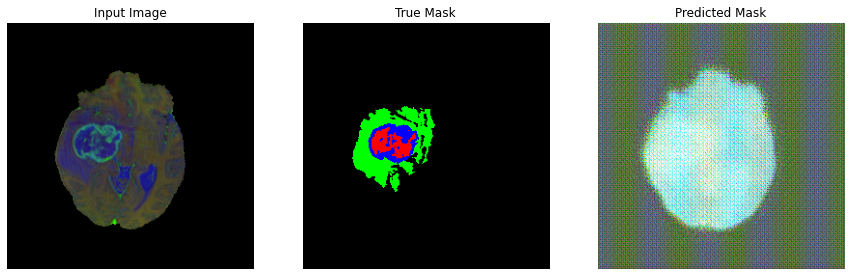

(8, 256, 256, 3)
(8, 256, 256, 3)


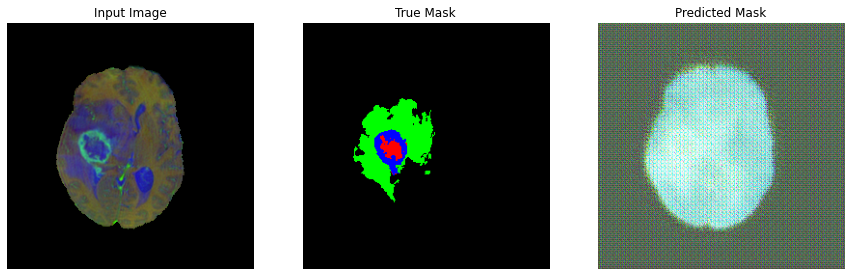

In [40]:
def show_predictions(dataset=None, num=1):
    if dataset:
        count = 0
        for image, mask in dataset:
            print(image.shape)
            print(mask.shape)
            pred_mask = manager_model.model.predict(image)
            display([image[0,...], mask[0,...], pred_mask[0,...]])
            if count < num:
                count += 1
            else:
                break
    else:
        display([sample_image, sample_mask, manager_model.model.predict(sample_image[tf.newaxis, ...])[0]])
show_predictions(dataset=train_dataset, num=3)

### Обучаем

In [ ]:

EPOCHS = 100
STEPS_PER_EPOCH = round(50)
VALIDATION_STEPS = round(1)
early_stop_val = 850
checkpoint_path = 'checkpoints2D//cp-{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_directory = os.path.join("Results", timestamp)

# Добавление отображения через TensorBoard.
log_dir = os.path.join("Results",
                       timestamp,
                       "logs",
                       "fit",
                       datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
full_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                       save_weights_only=True,
                                       save_freq=STEPS_PER_EPOCH,
                                       verbose=1),
    tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                   histogram_freq=1,
                                   profile_batch=0,
                                   write_images=True),
    tf.keras.callbacks.EarlyStopping(monitor="loss", patience=early_stop_val)]

model_history = manager_model.model.fit(train_dataset, epochs=EPOCHS,
                                        steps_per_epoch=STEPS_PER_EPOCH,
                                        validation_steps=VALIDATION_STEPS,
                                        validation_data=test_dataset,
                                        verbose=1,
                                        callbacks=full_callbacks)

manager_model.model.save(f"train.{Model.__name__}.{timestamp}")


(8, 256, 256, 3)
(8, 256, 256, 3)


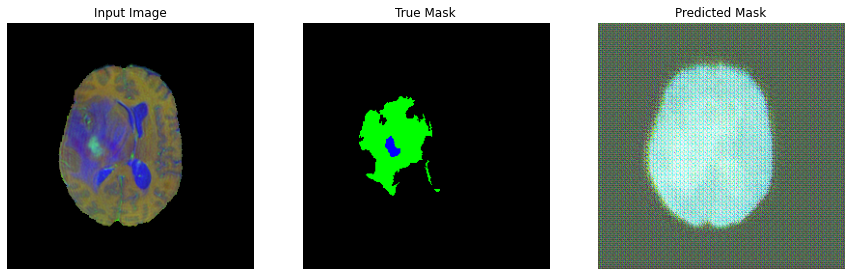

(8, 256, 256, 3)
(8, 256, 256, 3)


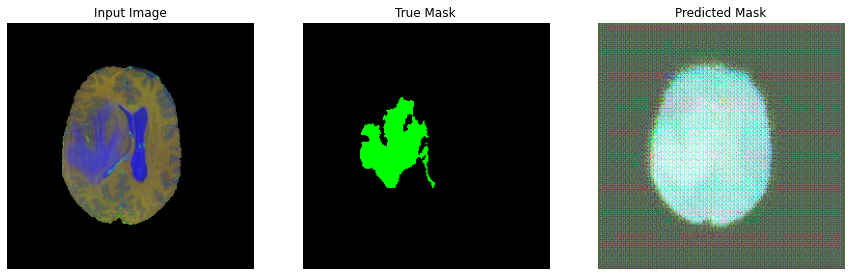

(8, 256, 256, 3)
(8, 256, 256, 3)


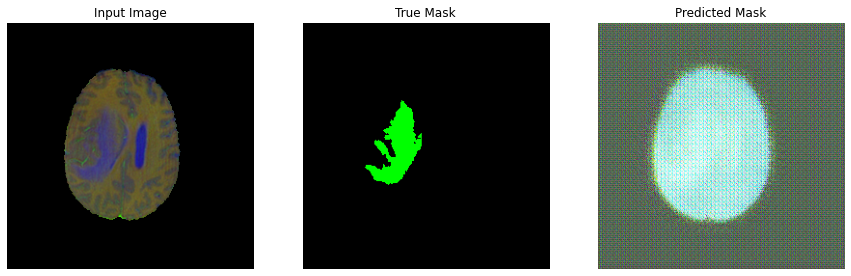

(8, 256, 256, 3)
(8, 256, 256, 3)


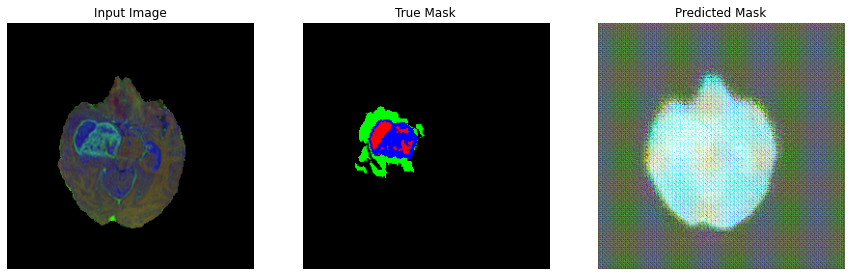

In [41]:
show_predictions(dataset=train_dataset, num=3)